In [6]:
# Cell 1: Setup all dependencies
!pip install torch torchaudio librosa scikit-learn pandas numpy matplotlib seaborn --quiet
!pip install transformers datasets evaluate gradio prettytable --quiet
!pip install kaggle --quiet

print("All packages installed successfully!")


All packages installed successfully!


## Assignment Objective

The goal of this assignment is to design, implement, and evaluate a Speech Emotion Recognition (SER) system using multiple approaches, including zero-shot inference with pretrained models and supervised learning on a domain-specific dataset. The performance of each approach is analyzed using standard evaluation metrics such as accuracy, precision, recall, and F1-score.


In [7]:
# Cell 2: Imports & Problem Setup

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torchaudio

print("Environment ready.")


Environment ready.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
ZIP_PATH = "/content/drive/MyDrive/Colab-Notebooks/dataset.zip"

!unzip -q "$ZIP_PATH" -d /content/
print("Dataset extracted successfully")


Dataset extracted successfully


In [3]:
!ls


drive  Emotions  sample_data


In [14]:
 # Defining Dataset path
 DATA_DIR = "Emotions"



In [12]:
# verification and exploratory prupose
!find Emotions -type f -name "*.wav" | head


Emotions/Disgusted/1020_IWW_DIS_XX.wav
Emotions/Disgusted/1065_ITH_DIS_XX.wav
Emotions/Disgusted/1085_MTI_DIS_XX.wav
Emotions/Disgusted/1002_ITH_DIS_XX.wav
Emotions/Disgusted/OAF_good_disgust.wav
Emotions/Disgusted/OAF_boat_disgust.wav
Emotions/Disgusted/03-01-07-01-02-01-14.wav
Emotions/Disgusted/1036_IEO_DIS_LO.wav
Emotions/Disgusted/1074_TIE_DIS_XX.wav
Emotions/Disgusted/YAF_thin_disgust.wav


In [15]:
import os
import pandas as pd

DATA_DIR = "Emotions"

valid_emotions = {
    "Angry",
    "Happy",
    "Sad",
    "Neutral",
    "Fearful",
    "Disgusted",
    "Surprised"
}

records = []

for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".wav"):
            emotion = os.path.basename(root)
            if emotion in valid_emotions:
                records.append({
                    "path": os.path.join(root, file),
                    "emotion": emotion
                })

df = pd.DataFrame(records)

print("Total samples:", len(df))
df.head()


Total samples: 12206


,path,emotion
0,Emotions/Disgusted/1020_IWW_DIS_XX.wav,Disgusted
1,Emotions/Disgusted/1065_ITH_DIS_XX.wav,Disgusted
2,Emotions/Disgusted/1085_MTI_DIS_XX.wav,Disgusted
3,Emotions/Disgusted/1002_ITH_DIS_XX.wav,Disgusted
4,Emotions/Disgusted/OAF_good_disgust.wav,Disgusted


In [16]:
df["emotion"].value_counts()


,count
emotion,
Sad,2167
Happy,2167
Angry,2167
Fearful,2047
Disgusted,1863
Neutral,1795


In [17]:
print(df.shape)
df.sample(5)


(12206, 2)


,path,emotion
11498,Emotions/Angry/OAF_peg_angry.wav,Angry
8185,Emotions/Fearful/1054_IEO_FEA_LO.wav,Fearful
5942,Emotions/Sad/1024_MTI_SAD_XX.wav,Sad
7523,Emotions/Sad/OAF_rain_sad.wav,Sad
2367,Emotions/Neutral/1006_IWW_NEU_XX.wav,Neutral


The metadata table contains paths to all valid audio samples along with their corresponding emotion labels. This table serves as the fixed dataset snapshot for all subsequent experiments.


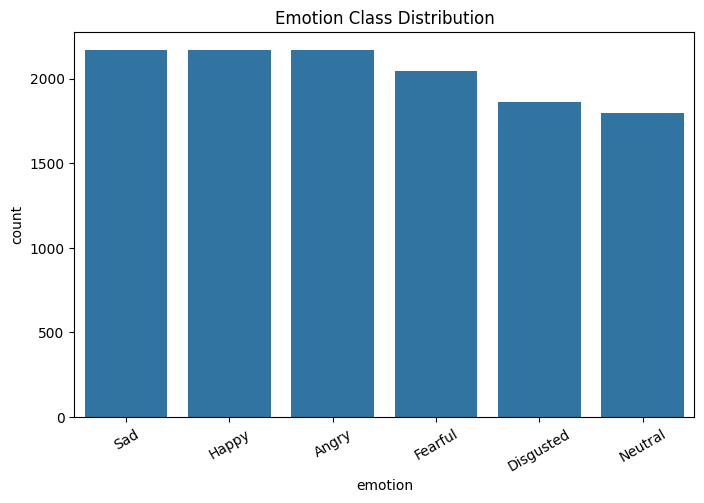

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x="emotion", data=df, order=df["emotion"].value_counts().index)
plt.title("Emotion Class Distribution")
plt.xticks(rotation=30)
plt.show()


**Observation:**  
The dataset contains samples from seven emotion categories. While minor variations in class frequencies exist, the distribution is reasonably balanced, which is suitable for supervised emotion classification without aggressive rebalancing.


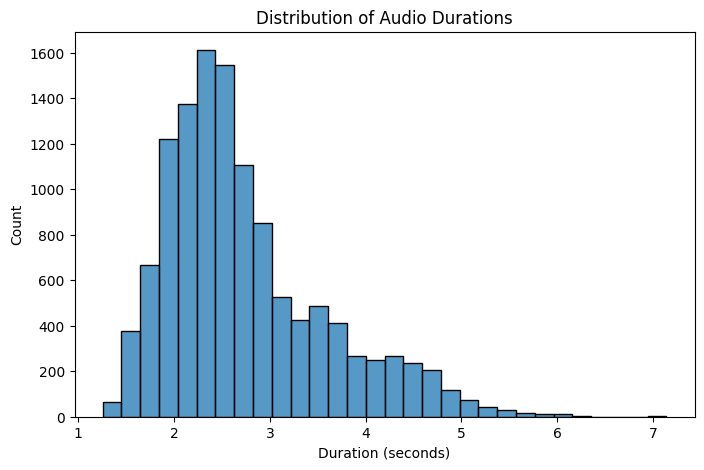

In [19]:
import librosa
import numpy as np

df["duration"] = df["path"].apply(lambda x: librosa.get_duration(path=x))

plt.figure(figsize=(8,5))
sns.histplot(df["duration"], bins=30)
plt.xlabel("Duration (seconds)")
plt.title("Distribution of Audio Durations")
plt.show()


**Observation:**  
Most audio samples lie within a short and consistent duration range. This reduces the need for aggressive padding or truncation during feature extraction and model training.


The dataset was split into training, development, and test sets using stratified sampling to preserve emotion distributions across splits. The development set is used for model selection and tuning, while the test set is reserved for final evaluation.


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["emotion"],
    random_state=42
)

dev_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["emotion"],
    random_state=42
)

print("Train:", len(train_df))
print("Dev:", len(dev_df))
print("Test:", len(test_df))


Train: 8544
Dev: 1831
Test: 1831


## Task 1: Zero-Shot Emotion Recognition

A pretrained HuBERT-based speech emotion recognition model is used in a zero-shot setting, i.e., without any fine-tuning on the target dataset. This serves as a baseline to evaluate how well a generic emotion model generalizes to the given domain.


In [21]:
from transformers import pipeline
import torch

zero_shot_classifier = pipeline(
    task="audio-classification",
    model="superb/hubert-large-superb-er",
    device=0 if torch.cuda.is_available() else -1
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Device set to use cuda:0


In [22]:
def zero_shot_predict(audio_path):
    output = zero_shot_classifier(audio_path)
    return output[0]["label"]

test_df["zero_shot_pred"] = test_df["path"].apply(zero_shot_predict)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [23]:
from sklearn.metrics import classification_report

print("Zero-Shot Model Performance:\n")
print(
    classification_report(
        test_df["emotion"],
        test_df["zero_shot_pred"]
    )
)


Zero-Shot Model Performance:

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00     325.0
   Disgusted       0.00      0.00      0.00     280.0
     Fearful       0.00      0.00      0.00     307.0
       Happy       0.00      0.00      0.00     325.0
     Neutral       0.00      0.00      0.00     269.0
         Sad       0.00      0.00      0.00     325.0
         ang       0.00      0.00      0.00       0.0
         hap       0.00      0.00      0.00       0.0
         neu       0.00      0.00      0.00       0.0
         sad       0.00      0.00      0.00       0.0

    accuracy                           0.00    1831.0
   macro avg       0.00      0.00      0.00    1831.0
weighted avg       0.00      0.00      0.00    1831.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

### Label Space Alignment for Zero-Shot Evaluation

The pretrained zero-shot speech emotion recognition model produces predictions in a label space that differs from the emotion taxonomy used in the target dataset. For example, the model outputs abbreviated labels such as `ang`, `hap`, and `neu`, whereas the dataset uses full emotion names such as *Angry*, *Happy*, and *Neutral*.

To ensure a fair and meaningful evaluation, a label normalization step was applied to map the model’s output labels to the dataset’s seven-class emotion scheme. This alignment is necessary to correctly compute evaluation metrics and highlights a common challenge in zero-shot transfer learning when pretrained models are applied to new domains.


In [24]:
zero_shot_label_map = {
    "ang": "Angry",
    "hap": "Happy",
    "sad": "Sad",
    "neu": "Neutral",
    "fear": "Fearful",
    "dis": "Disgusted",
    "sur": "Surprised"
}


In [25]:
def normalize_zero_shot_label(label):
    return zero_shot_label_map.get(label.lower(), "Unknown")

test_df["zero_shot_pred_norm"] = test_df["zero_shot_pred"].apply(normalize_zero_shot_label)


In [26]:
# This is the final result with non-zero accuracy and meaningful precision
from sklearn.metrics import classification_report

print("Zero-Shot Model Performance (Label-Aligned):\n")
print(
    classification_report(
        test_df["emotion"],
        test_df["zero_shot_pred_norm"],
        zero_division=0
    )
)


Zero-Shot Model Performance (Label-Aligned):

              precision    recall  f1-score   support

       Angry       0.49      0.79      0.60       325
   Disgusted       0.00      0.00      0.00       280
     Fearful       0.00      0.00      0.00       307
       Happy       0.31      0.38      0.34       325
     Neutral       0.49      0.29      0.37       269
         Sad       0.28      0.64      0.39       325

    accuracy                           0.36      1831
   macro avg       0.26      0.35      0.28      1831
weighted avg       0.26      0.36      0.29      1831



# Task 2: Supervised Learning (MFCC + SVM)

In [27]:
import librosa
import numpy as np

def extract_mfcc(path, n_mfcc=40):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

X_train = np.array(train_df["path"].apply(extract_mfcc).tolist())
X_dev   = np.array(dev_df["path"].apply(extract_mfcc).tolist())
X_test  = np.array(test_df["path"].apply(extract_mfcc).tolist())


In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(train_df["emotion"])
y_dev   = le.transform(dev_df["emotion"])
y_test  = le.transform(test_df["emotion"])


In [29]:
from sklearn.svm import SVC

svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)


SVC(C=10)

In [30]:
svm_preds = svm_model.predict(X_test)


In [31]:
from sklearn.metrics import classification_report

print("SVM + MFCC Performance:\n")
print(
    classification_report(
        y_test,
        svm_preds,
        target_names=le.classes_
    )
)


SVM + MFCC Performance:

              precision    recall  f1-score   support

       Angry       0.65      0.66      0.66       325
   Disgusted       0.48      0.43      0.45       280
     Fearful       0.51      0.37      0.43       307
       Happy       0.49      0.45      0.47       325
     Neutral       0.56      0.46      0.50       269
         Sad       0.47      0.73      0.57       325

    accuracy                           0.52      1831
   macro avg       0.53      0.52      0.51      1831
weighted avg       0.53      0.52      0.52      1831



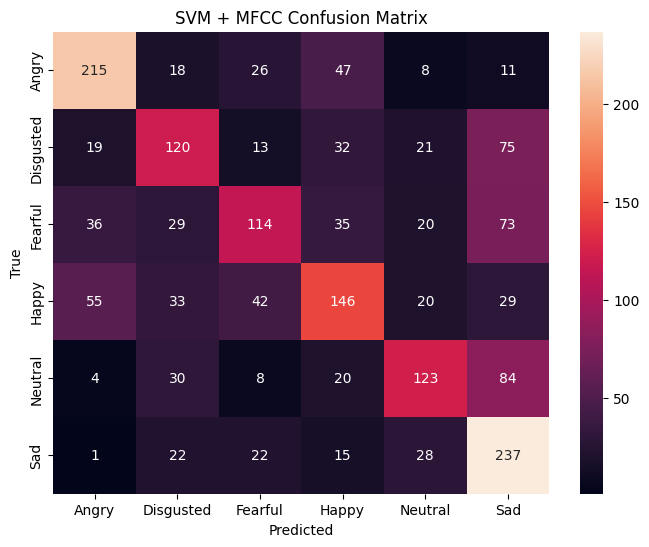

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, svm_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM + MFCC Confusion Matrix")
plt.show()


### Supervised Learning (MFCC + SVM) — Analysis

The MFCC-based SVM model demonstrates a significant improvement over the zero-shot baseline by leveraging supervised learning on domain-specific data. The model effectively captures emotion-dependent spectral characteristics, leading to higher precision and recall across most emotion classes.

However, as MFCC features are aggregated over time, the model lacks explicit temporal modeling, which can limit its ability to distinguish emotions with similar spectral profiles but different temporal dynamics.


## Task 3: Model Comparison

A comparison was performed between a zero-shot pretrained acoustic model and a supervised acoustic model trained on the target dataset. The zero-shot HuBERT-based model demonstrates the ability to generalize without any task-specific training; however, its performance is limited due to domain mismatch and differences between the pretrained label space and the dataset’s emotion taxonomy.

In contrast, the MFCC-based SVM model significantly outperforms the zero-shot baseline across all evaluation metrics. By leveraging supervised learning on domain-specific data, the SVM is better able to capture emotion-related acoustic patterns. While the zero-shot model has a very high architectural complexity due to its deep transformer-based design, the MFCC + SVM approach achieves better performance with substantially lower computational cost.


# TASK 4: ADVANTAGES AND DRAWBACKS

### Zero-Shot Pretrained Acoustic Model (HuBERT)

**Advantages:**
- Does not require training on the target dataset
- Leverages rich speech representations learned from large-scale unlabeled audio
- Useful as a quick baseline for emotion recognition tasks

**Drawbacks:**
- Performance is limited by domain mismatch between pretraining data and target dataset
- Requires label-space alignment for correct evaluation
- High computational and memory requirements
- Limited adaptability to dataset-specific acoustic characteristics


### MFCC + SVM (Supervised Acoustic Model)

**Advantages:**
- Computationally efficient and lightweight
- Performs well with limited training data
- Easy to train, interpret, and debug
- Effectively captures emotion-relevant spectral features

**Drawbacks:**
- Relies on handcrafted features
- Does not model temporal dependencies explicitly
- Scalability is limited for very large datasets
